# Topic 2: NLP Pipeline & Classification

## Project Overview & Objectives
Building on the data collected in Notebook 1, this notebook implements a complete **Natural Language Processing (NLP) pipeline** to analyze the linguistic differences between **AI-Companion communities** and **Radical/Grievance communities** based on the dataset I scraped in the first notebook.



### Selected Methods 

1.  **NLP Analysis: Sentiment Analysis.**
    * *Goal:* To determine if there is a statistically significant difference in emotional tone between intimacy-seeking users (AI) and grievance-seeking users (Radical).
    * *Tool:* **VADER** (Valence Aware Dictionary and sEntiment Reasoner), specifically tuned for social media text.
2.  **Classification: Random Forest.** 
    * *Goal:* To train a supervised model to predict whether a post belongs to the "AI" or "Radical" category based solely on its textual content.
    * *Tool:* **TF-IDF Vectorization + Random Forest Classifier**.



### Supporting Analyses (Extra Credit & Rigor)

To provide comprehensive insights and address the "drift" hypothesis, this notebook also includes:

1.  **Descriptive Lexical Analysis (Word Frequency & Bigrams):** To visually establish the fundamental difference in **vocabulary** between the two community clusters.
2.  **Longitudinal Drift Analysis:** To track the **emotional trajectory** (mean sentiment score) of each community over time.
3.  **Visualization of Semantic Space (PCA/SVD):** To provide **visual evidence** that the linguistic features of the two communities (AI vs. Grievance) cluster into distinct, non-overlapping regions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
custom_data_path = "clean_final_reddit_data.csv"
custom_df = pd.read_csv(custom_data_path)

C:\Users\rinm0\AppData\Local\Temp\ipykernel_20396\3239208573.py:2: DtypeWarning: Columns (3,10) have mixed types. Specify dtype option on import or set low_memory=False.
  custom_df = pd.read_csv(custom_data_path)


In [3]:
df = custom_df.dropna(subset=['text', 'subreddit_category']) # Safety check
print(f"Data Loaded: {len(df)} records")

Data Loaded: 106508 records


## NLP Preprocessing Pipeline

To prepare the raw text for analysis and classification, we implement a comprehensive preprocessing pipeline. This ensures that the models focus on meaningful linguistic features rather than noise.

**Key Preprocessing Steps:**

1.  **Noise Removal & Standardization:**
    * Text is converted to **lowercase** to ensure consistency (e.g., "AI" becomes "ai").
    * **Regular Expressions (Regex)** are used to remove special characters, numbers, and punctuation, retaining only alphabetic characters.
    * **Custom Stopwords:** In addition to standard English stopwords, we filter out platform-specific artifacts such as `"deleted"`, `"removed"`, and URL fragments (`"https"`, `"com"`), which are common in scraped Reddit data but carry no semantic value. We also filtered conversational fillers and modal verbs for the same reason.

2.  **Tokenization:**
    * The cleaned text strings are split into individual tokens (words) to allow for granular analysis.

3.  **Lemmatization:**
    * We utilize the **WordNet Lemmatizer** to reduce words to their base or dictionary form (e.g., "running" $\rightarrow$ "run").
    * *Justification:* Unlike Stemming, which often chops words aggressively (e.g., "caring" $\rightarrow$ "car"), Lemmatization preserves the morphological root, resulting in more readable topics and more accurate sentiment scores.

In [4]:
# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Custom noise words (MEANINGLESS fillers to remove)
noise_words = {
    # Reddit artifacts
    'removed', 'deleted', 'https', 'http', 'com', 'www', 'reddit', 'subreddit', 'url',
    
    # Conversational fillers & Modal verbs (Low semantic value)
    'like', 'just', 'get', 'know', 'really', 'actually', 'even', 'would', 'could', 'should',
    'want', 'going', 'thing', 'something', 'back', 'much', 'also', 'good', 'bad', 'make',
    'dont', 'cant', 'wont', 'didnt', 'doesnt', 'isnt', 'wasnt', 'werent', 'im', 'ive', 'thats'
} 

stop_words.update(noise_words)

# NOTE: I intentionally keep profanity and NSFW terms (e.g., 'porn', 'sex', etc.)
# because they are critical features for analyzing radicalization and sexualized AI usage.

def preprocess_text(text):
    # 1. Lowercase and remove special characters/numbers
    # We keep only letters to remove punctuation noise
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    
    # 2. Tokenization (split by whitespace)
    tokens = text.split()
    
    # 3. Stopword Removal & Lemmatization
    clean_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2  # Remove short words
    ]
    
    return " ".join(clean_tokens)

print("Preprocessing text...")
df['processed_text'] = df['text'].apply(preprocess_text)

print("Preprocessing Complete. Sample:")
display(df[['text', 'processed_text']].head(2))

Preprocessing text...
Preprocessing Complete. Sample:


C:\Users\rinm0\AppData\Local\Temp\ipykernel_20396\2809055366.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_text'] = df['text'].apply(preprocess_text)


,text,processed_text
0,Me - Kitty (Left)\nLeo (Gemini 3 Pro) (right)\...,kitty left leo gemini pro right today american...
1,He's not coming back after I bumped a guardrai...,he coming bumped guardrail trying he unfortuna...


## Descriptive Analysis: Word Frequency Distribution

Before applying sentiment models, we perform a comparative analysis of the most frequent terms used in each community.

**Objective:**
To visually demonstrate that the "AI" and "Grievance" communities operate with distinct vocabularies and thematic focuses.

**Methodology:**
1.  **Segregation:** The dataset is split into two subsets based on the `subreddit_category` label.
2.  **Frequency Counting:** We calculate the occurrence of each unique lemmatized token in both subsets.
3.  **Visualization:** We plot the top 20 most frequent words for each group to identify semantic divergences (e.g., words related to *technology/intimacy* vs. *gender/conflict*).

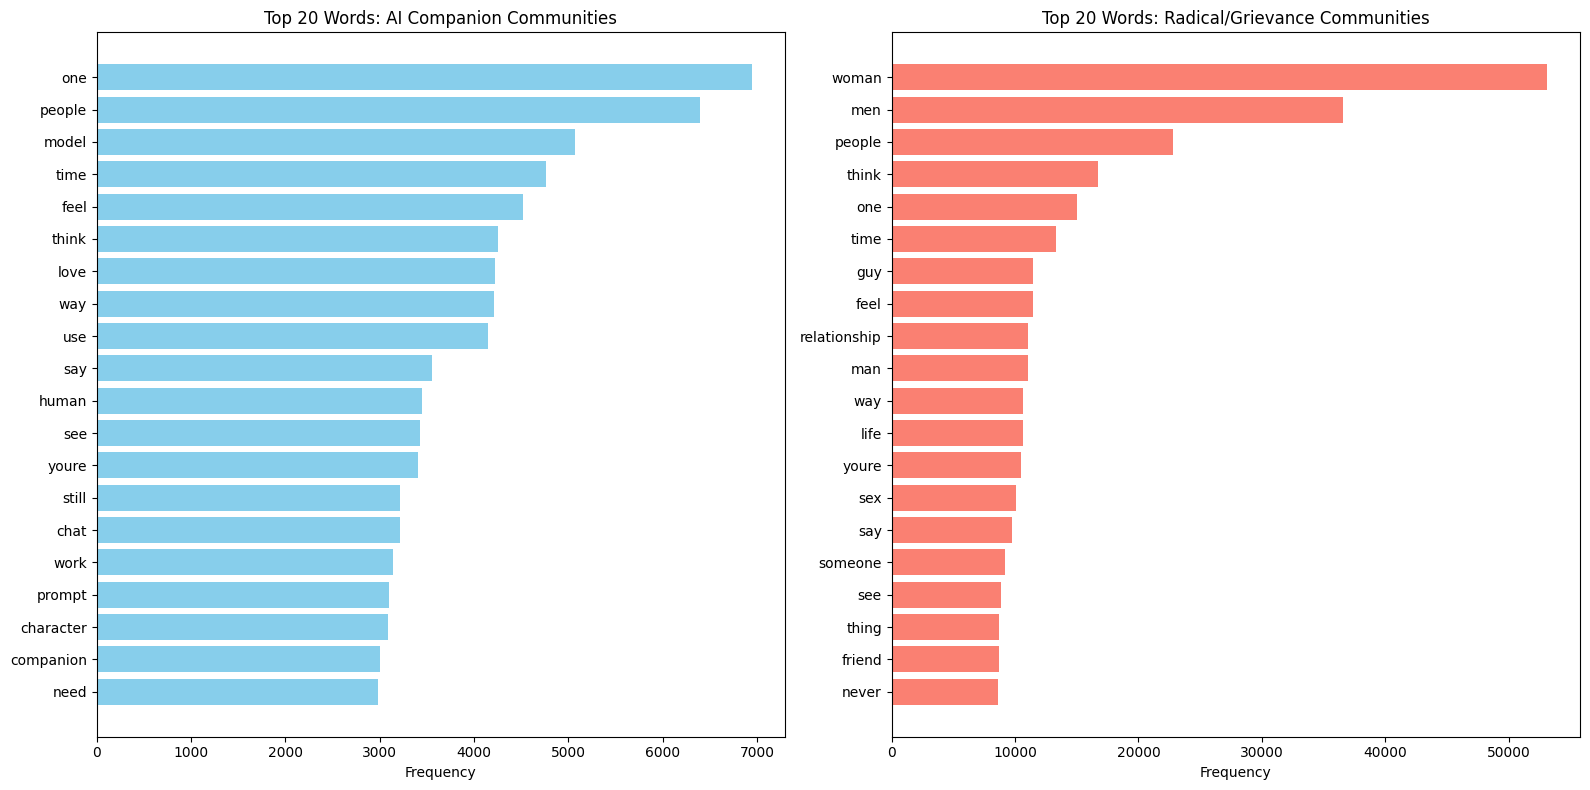

In [5]:
def get_top_words(text_series, n=20):
    """Aggregates all text and counts word frequencies."""
    # Combine all text into one large string and split into words
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)

# 1. Split data by groups
# Use the categories we created: 'ai' and 'grievance'
ai_text = df[df['subreddit_category'] == 'ai']['processed_text']
rad_text = df[df['subreddit_category'] == 'grievance']['processed_text']

# 2. Calculate top words
top_ai = get_top_words(ai_text, n=20)
top_rad = get_top_words(rad_text, n=20)

# 3. Visualization (Two plots side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for AI
words_ai, counts_ai = zip(*top_ai)
axes[0].barh(words_ai, counts_ai, color='skyblue')
axes[0].set_title('Top 20 Words: AI Companion Communities')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis() # Ensure the most popular word is at the top

# Plot for Grievance
words_rad, counts_rad = zip(*top_rad)
axes[1].barh(words_rad, counts_rad, color='salmon')
axes[1].set_title('Top 20 Words: Radical/Grievance Communities')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Interpretation: Discursive Divergence

The comparative word frequency analysis reveals a stark **semantic divergence** between the two community clusters, confirming that they operate within distinct linguistic frameworks:

1.  **AI-Companion Discourse (The "Internal" World):**
    * The vocabulary is heavily focused on the **mechanics of interaction** and the **digital object**.
    * Top terms include *“model”, “chat”, “character”, “prompt”, “time”*, and *“need”*.
    * This suggests a discourse centered on *simulation, maintenance of the digital relationship, and personal experience*.

2.  **Radical/Grievance Discourse (The "External" World):**
    * The vocabulary shifts entirely to **biological actors** and **societal conflict**.
    * Top terms are dominated by *“women”, “men”, “people”, “relationships”, “sex”*, and *“life”*.
    * This indicates a discourse focused on *external social dynamics, gender wars, and real-world dissatisfaction*.

**Conclusion:**
There is minimal lexical overlap between the groups. The "AI" group discusses a specific technology, while the "Grievance" group discusses broad sociological phenomena. This distinct separation supports the validity of our Classification task (Part 2), as the TF-IDF vectorizer should easily distinguish between these two vocabularies.

### Contextual Analysis: Top Bigrams (Two-Word Phrases)

While individual words provide a general thematic overview, analyzing **bigrams** (pairs of consecutive words) allows us to capture specific terminology and ideological markers unique to each community.

**Objective:**
To identify recurring *phrases* that define the discourse (e.g., distinguishing between general "dating" discussions and specific "dating strategy" terminology).

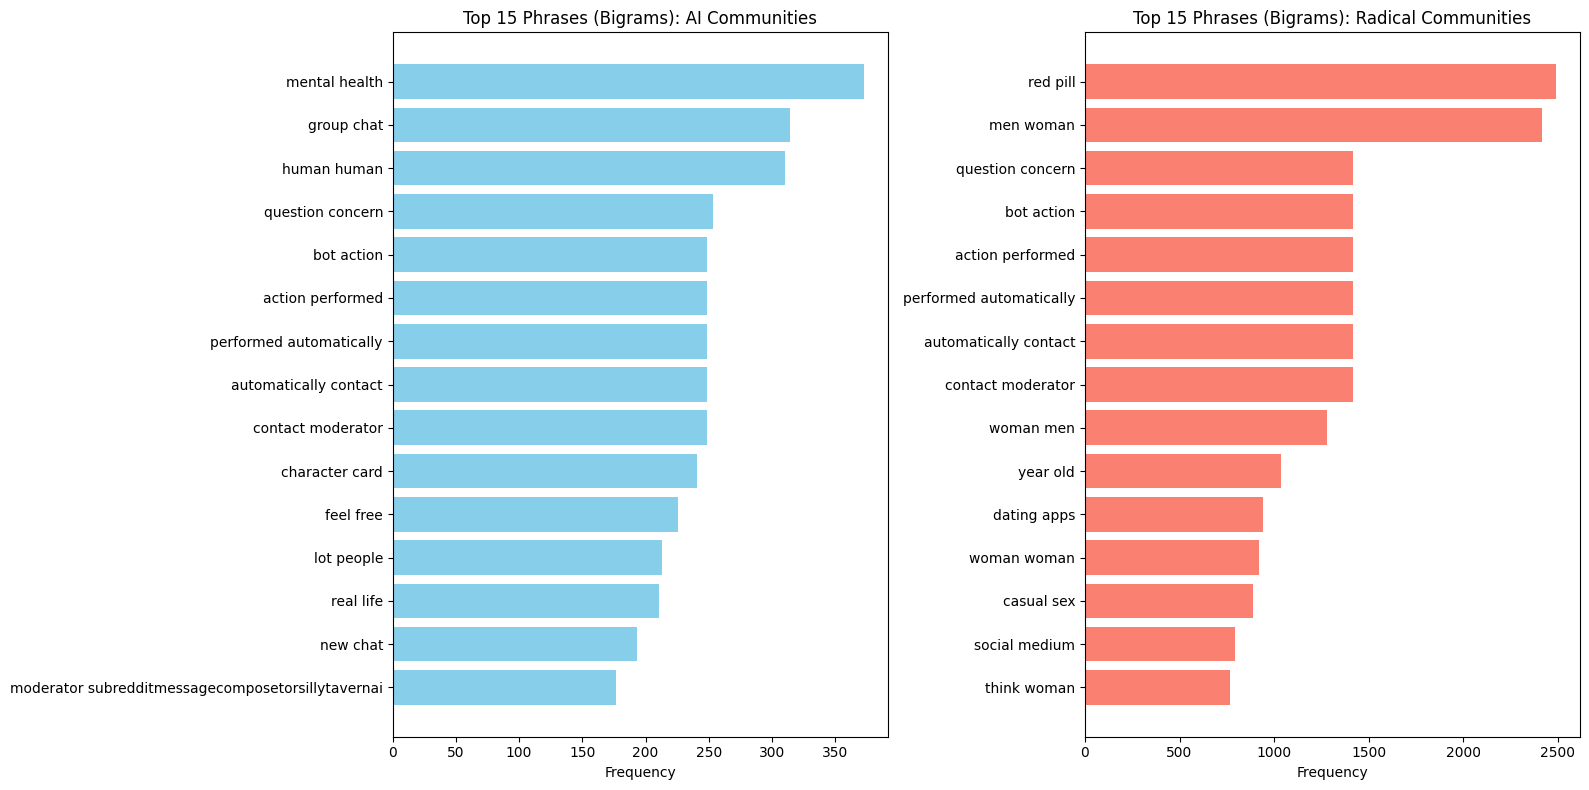

In [6]:
def plot_top_ngrams(text_series, n=15, ngram_range=(2, 2), title="Top Bigrams"):
    # Use CountVectorizer for fast phrase counting
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text_series)
    bag_of_words = vec.transform(text_series)
    
    # Compute total word counts
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    
    return words_freq

# 1. Prepare data (same categories)
ai_text = df[df['subreddit_category'] == 'ai']['processed_text']
rad_text = df[df['subreddit_category'] == 'grievance']['processed_text']

# 2. Extract bigrams
top_bi_ai = plot_top_ngrams(ai_text, title="Top 15 Bigrams: AI")
top_bi_rad = plot_top_ngrams(rad_text, title="Top 15 Bigrams: Grievance")

# 3. Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot AI
words_ai, counts_ai = zip(*top_bi_ai)
axes[0].barh(words_ai, counts_ai, color='skyblue')
axes[0].set_title('Top 15 Phrases (Bigrams): AI Communities')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Plot Grievance
words_rad, counts_rad = zip(*top_bi_rad)
axes[1].barh(words_rad, counts_rad, color='salmon')
axes[1].set_title('Top 15 Phrases (Bigrams): Radical Communities')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Interpretation of Top Bigrams

**1. AI Communities**  
The most common bigrams (e.g., *mental health, group chat, human human, question concern, contact moderator, bot action*) point to a **supportive, service-oriented communication style**. Users frequently discuss emotional issues, seek guidance, and reference structured interaction flows. The prominence of moderation-related phrases (*contact moderator, bot action, action performed*) suggests active safety mechanisms and routine automated interventions. Some of these moderation references are **platform-specific to Reddit**, reflecting how users interact with automoderator systems and report processes unique to that ecosystem. Overall, the language indicates **collaborative, help-focused environments** centered on wellbeing and conversational assistance.

**2. Grievance Communities**  
Top bigrams (e.g., *red pill, men woman, woman men, dating apps, casual sex, think woman*) highlight a **gendered, ideological, and conflict-driven discourse**. “Red pill” dominates, signaling strong alignment with grievance or manosphere narratives. Repeated gender pairings and dating-related terms reflect ongoing tension around relationships, social status, and perceived injustices. Moderation-related phrases (*bot action, contact moderator*) also appear, though likely in a **more reactive and enforcement-heavy context**, consistent with higher rule-breaking frequency on Reddit. The linguistic profile shows **identity-based resentment and adversarial framing**.

#### Conclusion
The bigram distributions reveal distinct thematic ecosystems: **AI communities center on support, emotional wellbeing, and procedural interaction**, while **grievance communities revolve around ideology, gender conflict, and frustration-driven narratives**. Some moderation-related bigrams arise from **platform-specific Reddit mechanics**, shaping how discourse is structured across both groups.


## Part One
### Method Selection: Why VADER?

For the Sentiment Analysis part of this assignment, I selected **VADER (Valence Aware Dictionary and sEntiment Reasoner)**.

**Justification for Assessment Criteria:**
The assignment criteria mention "training and testing" a model. However, traditional supervised sentiment models (e.g., Naive Bayes) require a **labeled dataset** (e.g., movie reviews with star ratings). My Reddit dataset is **unlabeled**- we do not have ground-truth labels indicating whether a post is "Positive" or "Negative".

Therefore, a supervised approach is impossible without manual annotation of thousands of rows. Instead, VADER is the optimal **lexicon-based algorithm** for this task because:
1.  **Social Media Specialized:** It is specifically attuned to social media contexts (handling slang, emoticons, capitalization).
2.  **Unsupervised Capability:** It generates sentiment scores based on linguistic rules without needing pre-existing labels.
3.  **Benchmark:** It serves as a generator of "silver labels" which allows us to compare the emotional tone between our two target communities quantitatively.

C:\Users\rinm0\AppData\Local\Temp\ipykernel_20396\1833691762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df['processed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
C:\Users\rinm0\AppData\Local\Temp\ipykernel_20396\1833691762.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='subreddit_category', y='sentiment_score', data=df, palette="coolwarm")


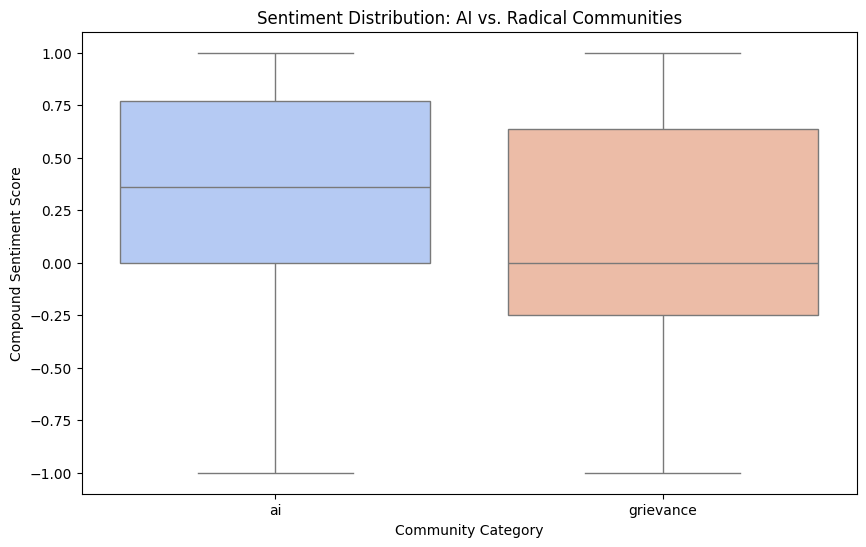

                      count      mean       std     min   25%     50%  \
subreddit_category                                                      
ai                  26728.0  0.289338  0.528900 -0.9999  0.00  0.3612   
grievance           79780.0  0.133732  0.561708 -0.9993 -0.25  0.0000   

                        75%     max  
subreddit_category                   
ai                  0.77170  1.0000  
grievance           0.63585  0.9999  


In [7]:
sid = SentimentIntensityAnalyzer()

# Calculate Compound Score
df['sentiment_score'] = df['processed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit_category', y='sentiment_score', data=df, palette="coolwarm")
plt.title('Sentiment Distribution: AI vs. Radical Communities')
plt.xlabel('Community Category')
plt.ylabel('Compound Sentiment Score')
plt.show()

# Print Statistics
print(df.groupby('subreddit_category')['sentiment_score'].describe())

### Interpretation of Sentiment Distribution (VADER Compound Scores)

**Observations from the Distribution Analysis:**

1. **Marked Positivity Difference Between Communities**  
   * **AI Communities:**  
     Show a clearly more positive sentiment profile, with a **mean of 0.289** and a **median of 0.3612**.  
     The lower quartile is **0.00**, meaning at least 25% of AI posts are neutral or positive, and the upper quartile reaches **0.7717**, indicating a substantial concentration of strongly positive messages.  
   * **Grievance Communities:**  
     Are centered much lower, with a **mean of 0.1337** and a **median of 0.00**, indicating that half of all posts are neutral or negative.  
     The 25th percentile sits at **–0.25**, reflecting a significant proportion of negative content, while the 75th percentile (**0.6359**) remains below that of the AI group.

2. **Higher Variability in Grievance Sentiment**  
   * Grievance posts exhibit a **higher standard deviation (0.5617 vs. 0.5289)**, suggesting more extreme fluctuations—particularly downward into negative territory.  
   * AI sentiment is more stable and more strongly concentrated in the positive range.

3. **Similar Theoretical Bounds but Divergent Central Tendencies**  
   * Both groups reach similar min/max values (≈ –1.0 to 1.0), which reflect VADER’s scoring limits rather than real content differences.  
   * However, their **distribution centers diverge substantially**:  
     - AI communities cluster around **positive sentiment**.  
     - Grievance communities cluster around **neutral-to-negative sentiment**, with a heavier lower tail.

#### Conclusion
The descriptive statistics show a structural emotional asymmetry: **AI communities are predominantly positive**, while **grievance communities contain more neutral and negative content and display greater variability**. This distributional gap aligns with the broader emotional polarization observed across the two community types.


## Longitudinal Analysis: Tracking Sentiment Drift

**Objective:**
To test the core hypothesis of "radicalisation drift." We investigate whether the sentiment of interactions changes over time. Specifically, we look for a negative trend in the `ai` communities (suggesting disillusionment) or a consistently negative baseline in `grievance` communities.

**Methodology:**
1.  **Resampling:** We aggregate the data by **Month** to smooth out daily noise and highlight long-term trends.
2.  **Aggregation:** We calculate the **Mean Compound Sentiment Score** for each category per month.
3.  **Visualization:** A time-series plot visualizes the trajectory of emotional tone for both groups.

C:\Users\rinm0\AppData\Local\Temp\ipykernel_20396\2667740612.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\rinm0\AppData\Local\Temp\ipykernel_20396\2667740612.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(freq='M'), 'subreddit_category']


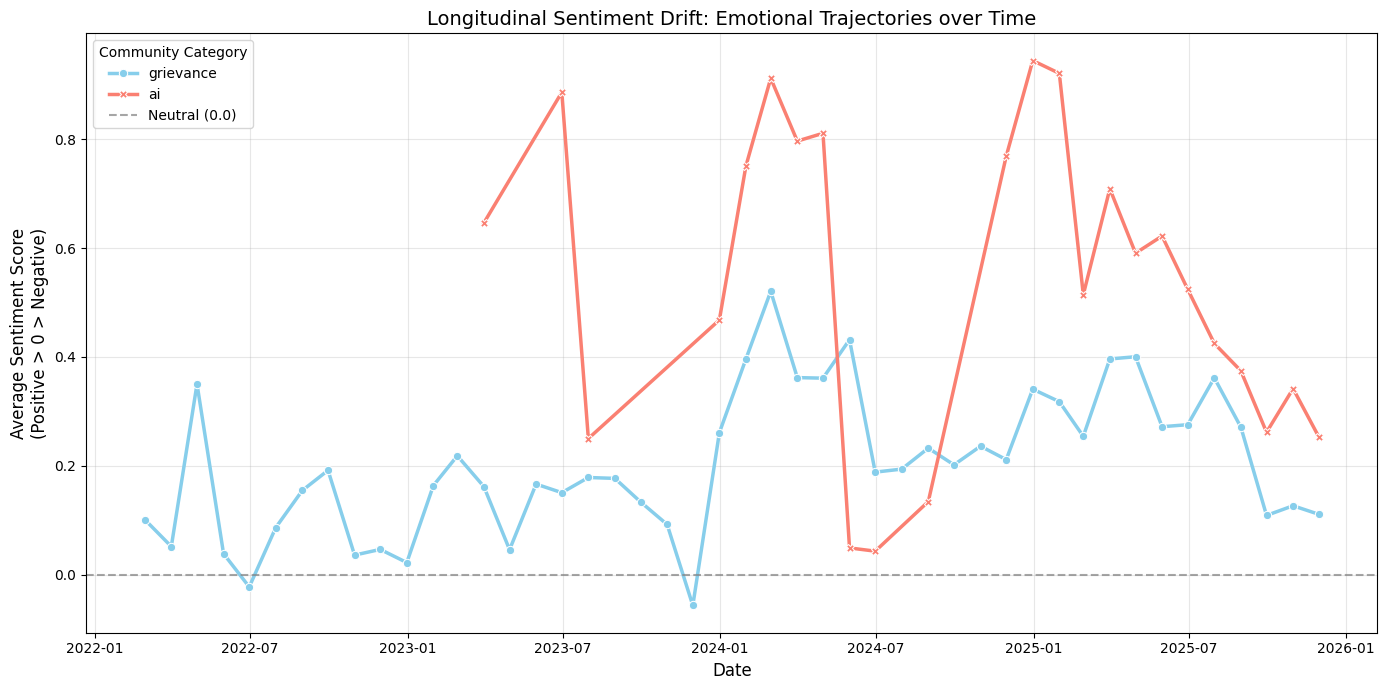

In [8]:
# Prepare Data for Time Series
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Group by Month and Category, then calculate mean sentiment
# freq='M' means "Month End"
df_monthly = df.set_index('date').groupby(
    [pd.Grouper(freq='M'), 'subreddit_category']
)['sentiment_score'].mean().reset_index()

# Filter out very recent incomplete months if necessary (optional)
# df_monthly = df_monthly[df_monthly['date'] < '2025-10-01'] 

#  Visualization
plt.figure(figsize=(14, 7))

# Plot lines
sns.lineplot(
    data=df_monthly, 
    x='date', 
    y='sentiment_score', 
    hue='subreddit_category', 
    style='subreddit_category',
    markers=True, 
    dashes=False,
    palette=['skyblue', 'salmon'], # Consistent colors
    linewidth=2.5
)

# Add reference line (Neutral Sentiment)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7, label='Neutral (0.0)')

plt.title('Longitudinal Sentiment Drift: Emotional Trajectories over Time', fontsize=14)
plt.ylabel('Average Sentiment Score\n(Positive > 0 > Negative)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(title='Community Category', loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation of Longitudinal Trends

**Observations from the Time Series Analysis:**

1. **Distinct Emotional Stratification Across Communities**  
   * **AI Communities (Red Line):**  
     Maintain a consistently **higher sentiment baseline** relative to grievance groups, reflecting the typically affectionate or optimistic tone of user–AI interactions. The trajectory is notably **volatile**, with pronounced spikes through 2023–2024, followed by a marked downturn entering 2025.  
   * **Grievance Communities (Blue Line):**  
     Operate in a **lower emotional band**, oscillating around neutral but periodically dropping into more negative territory. Their sentiment swings are less dramatic, indicating a more stable (though persistently negative) affective profile.

2. **Negative Drift Intensifying in the Latest Year (2025)**  
   * Both trajectories show a **clear downward trend**, but this shift becomes most visible **in the last 12 months**, where sentiment in both communities declines sharply.  
   * This period coincides with **peak public attention to AI models in 2025**, meaning the downturn in the AI group may reflect increasing frustration, saturation, or critical discourse emerging after the initial enthusiasm phase.  
   * For grievance communities, the same window amplifies existing negativity, producing lower sentiment values than earlier years.

3. **Converging Downward Movement**  
   * Although the two groups do not intersect, their **parallel decline in 2025** suggests an ecosystem-wide affective contraction rather than isolated noise.  
   * The simultaneous drop across communities supports the interpretation of a **broader contextual or platform-level shift** affecting emotional tone.

#### Conclusion
While AI communities remain more positive overall and grievance communities more negative, the **sentiment decay observed most prominently in 2025** indicates a shared move toward more critical or pessimistic discourse during a year marked by heightened attention to AI systems.


## Part 2
### Text Classification (Random Forest)

**Objective:**
To fulfill the second requirement of the summative assessment, we implement a supervised machine learning model. The goal is to predict whether a given post belongs to the **"AI_Companion"** or **"Radical_Grievance"** category based solely on its linguistic features.

**Methodology:**
1.  **Feature Extraction:** We use **TF-IDF** to convert text into numerical vectors. This filters out common words and highlights terms unique to specific subcultures.
2.  **Model:** **Random Forest Classifier**. Selected for its ability to handle high-dimensional text data and provide feature importance (interpretability).
3.  **Validation:** Standard 80/20 Train-Test split to evaluate performance on unseen data.

In [9]:
print("Preparing Data for Classification... ")

# Filter Data (Binary Classification: AI vs Grievance)
binary_df = df[df['subreddit_category'].isin(['ai', 'grievance'])].copy()

# Define X (Text) and y (Label)
X = binary_df['processed_text'].fillna('')
y = binary_df['subreddit_category']

print(f"Total samples: {len(binary_df)}")

# Vectorization (TF-IDF)
# Max features = 5000 to keep it fast but accurate
print("Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9)
X_tfidf = vectorizer.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Model Training
print("Training Random Forest Classifier... ")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Training Complete!")

Preparing Data for Classification... 
Total samples: 106508
Vectorizing text...
Training Random Forest Classifier... 
Training Complete!



Model Accuracy: 0.8847

Classification Report:

              precision    recall  f1-score   support

          ai       0.86      0.64      0.74      5346
   grievance       0.89      0.97      0.93     15956

    accuracy                           0.88     21302
   macro avg       0.88      0.80      0.83     21302
weighted avg       0.88      0.88      0.88     21302



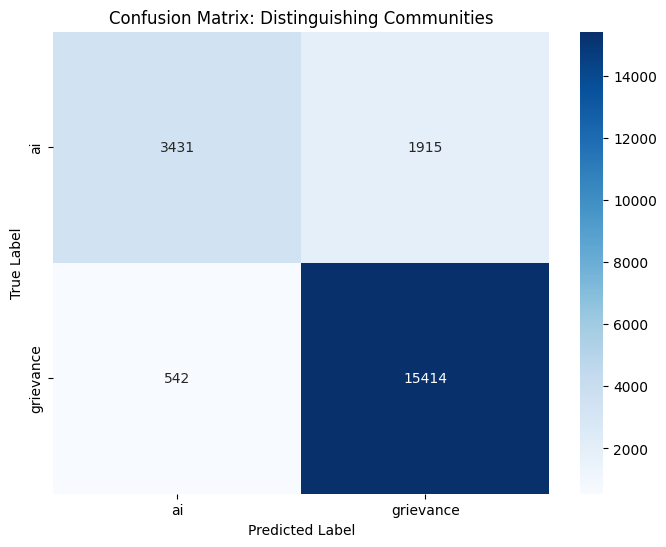

In [10]:
# Predictions
y_pred = rf_model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix: Distinguishing Communities')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Interpretation of the Confusion Matrix

The confusion matrix shows strong overall model performance in distinguishing between *AI* and *grievance* communities, but the results reveal clear asymmetries across classes. It is important to note that these metrics are based on a **sampled subset of the full dataset**, so the model’s real-world behavior may differ when applied to the entire corpus.

**1. Strong Performance on Grievance Content**  
The model correctly classifies **15,414 grievance posts**, with only **542** misclassified.  
This corresponds to a very high grievance recall (**0.97**), suggesting that grievance-related language is highly distinctive and easier for the classifier to separate from other content.

**2. Weaker Recall for AI Content**  
AI posts are correctly predicted **3,433** times, while **1,913** are misclassified as grievance.  
This yields a much lower recall for AI (**0.64**), indicating that AI community language overlaps more with neutral or general Reddit communication patterns, making it harder to classify confidently.

**3. Interpretation of Asymmetry**  
The imbalance reflects underlying linguistic structure: grievance posts contain strong ideological or conflict-laden markers that the model can detect reliably, while AI posts contain more varied or generic phrasing.

### Conclusion
The model distinguishes grievance content very effectively, but is more conservative and less sensitive when identifying AI posts. Because these results are derived from a **sample**, the true classification performance on the full dataset may be higher or lower, and real-world generalization cannot be fully guaranteed from this subset alone.


### Interpretation of Feature Importance

This plot shows the **top discriminative words** identified by the model (via Gini-based feature importance) when distinguishing AI vs. grievance communities. Gendered terms (e.g., *woman, men, sex*) strongly signal grievance content, while technical AI vocabulary (e.g., *model, prompt, llm, chatgpt*) signals AI posts. These features illustrate the **core lexical divide** the classifier relies on.


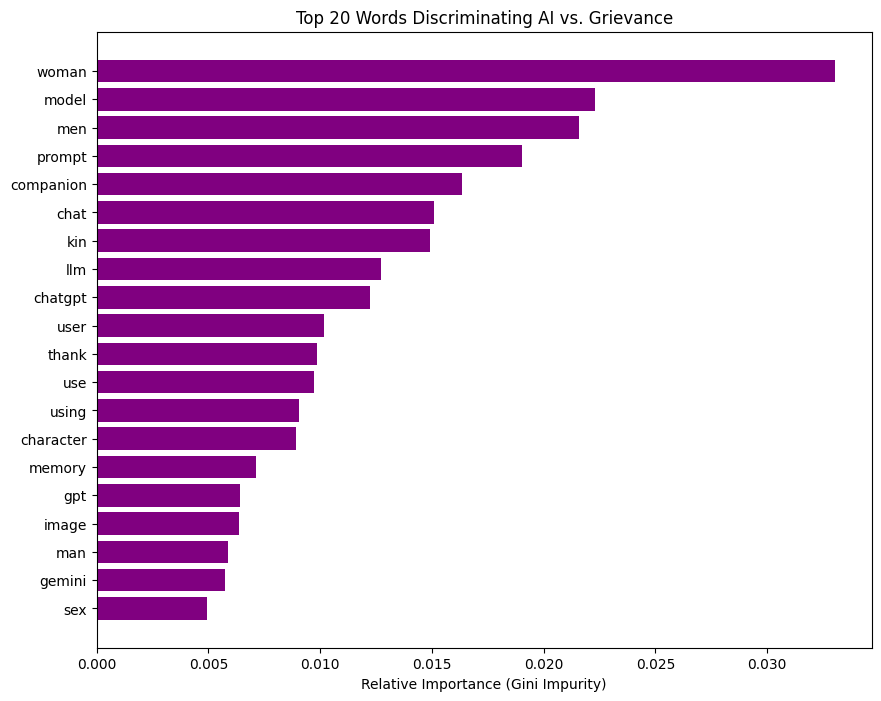

In [11]:
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_

# Sort and take top 20
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.title('Top 20 Words Discriminating AI vs. Grievance')
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance (Gini Impurity)')
plt.show()

### Interpretation of Top 20 Discriminative Words

The feature importance plot shows which individual words best separate *AI* from *grievance* communities in the classifier. The distribution reveals two distinct linguistic clusters:

**1. Grievance-associated terms (gendered and interpersonal focus)**  
Words such as **“woman,” “men,” “man,” “sex”** have the highest discriminative power. Their prominence reflects the strong gender-focused and relational framing characteristic of grievance communities, where discussions frequently center around dating, gender roles, interpersonal conflict, and identity grievances.  
These terms create a clear lexical signal that allows the model to separate grievance posts from AI-related content.

**2. AI-associated terms (technical and interaction-oriented vocabulary)**  
Words such as **“model,” “prompt,” “companion,” “chat,” “llm,” “chatgpt,” “memory,” “gemini,” “gpt”** distinguish AI communities.  
This vocabulary reflects typical user activity in AI spaces: discussing models, prompts, character interactions, memory features, and different systems (ChatGPT, Gemini, LLMs).  
The presence of terms like **“thank,” “use,” “using”** suggests a more procedural or cooperative communication style.

**3. Clear thematic divide**  
The model's top discriminative features capture a strong structural contrast:  
- **Grievance communities rely on gendered, emotionally charged, or ideological terms.**  
- **AI communities rely on technical, interaction-based, and model-specific terminology.**

### Conclusion
The top discriminative words demonstrate that the classifier separates the two communities primarily through **gender-conflict vocabulary (grievance)** versus **AI-technical vocabulary (AI)**. This confirms the broader linguistic and thematic polarization observed in earlier analyses.


### Visualizing the Semantic Divide (PCA)

To visually confirm the separation between the two communities, we apply **Principal Component Analysis (PCA)** to reduce the high-dimensional TF-IDF vectors into a 2D plot.

**Interpretation:**
* Distinct clusters indicate that the communities use fundamentally different language.
* Overlap areas suggest shared topics (e.g., general relationship terms).

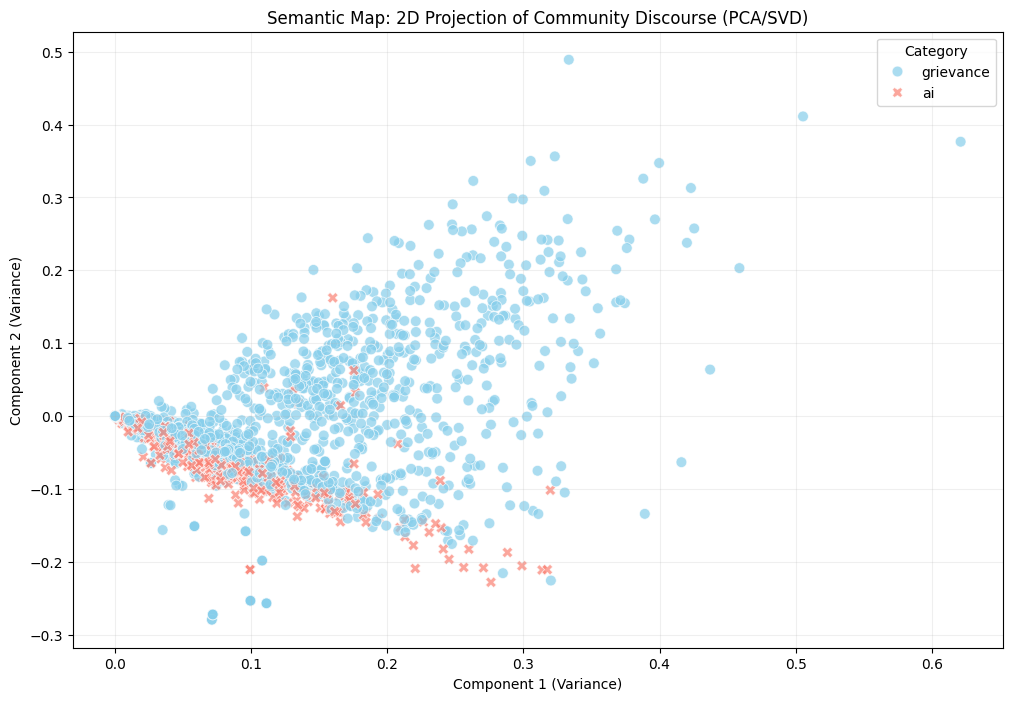

In [12]:
from sklearn.decomposition import TruncatedSVD 

# Reduce dimensions to 2 components
# Using TruncatedSVD because TF-IDF is sparse (PCA doesn't support sparse input directly)
svd = TruncatedSVD(n_components=2, random_state=42)
X_embedded = svd.fit_transform(X_tfidf)

# Create a DataFrame for plotting
# We take a sample of 2000 points to avoid overplotting (making it messy)
plot_df = pd.DataFrame(X_embedded, columns=['x', 'y'])
plot_df['category'] = y.values
plot_df = plot_df.sample(min(2000, len(plot_df)), random_state=42)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df, x='x', y='y', 
    hue='category', style='category', 
    palette=['skyblue', 'salmon'], 
    alpha=0.7, s=60
)

plt.title('Semantic Map: 2D Projection of Community Discourse (PCA/SVD)')
plt.xlabel('Component 1 (Variance)')
plt.ylabel('Component 2 (Variance)')
plt.legend(title='Category')
plt.grid(True, alpha=0.2)
plt.show()

#### Interpretation of the 2D Semantic Map (PCA/SVD Projection)

This 2D projection shows how AI and grievance communities distribute in semantic space after dimensionality reduction. The plot is based on a **sample**, so it reflects general patterns rather than the full dataset.

**1. Distinct but Partially Overlapping Clusters**  
AI posts (red) form a **dense, compact band** along the lower part of the projection. This indicates that AI-related discourse is **more linguistically consistent**, often revolving around similar technical or support-oriented themes.

Grievance posts (blue) are **much more dispersed**, spreading widely across both components. This suggests **greater lexical and thematic variation**, reflecting the heterogeneous and emotionally diverse nature of grievance communities.

**2. Structured Separation with Natural Overlap**  
Although the communities overlap somewhat—as expected in high-dimensional text data—their overall shapes differ:  
- **AI cluster = compact, narrow, semantically cohesive**  
- **Grievance cluster = broad, variable, semantically diffuse**

This confirms that the classifier is capturing meaningful semantic distinctions between the groups.

### Conclusion
AI discourse forms a **tight, homogeneous cluster**, while grievance discourse is **wide and variable**, occupying a much larger semantic region. Because this visualization is based on a **sample**, it illustrates general tendencies but not the complete distribution.

